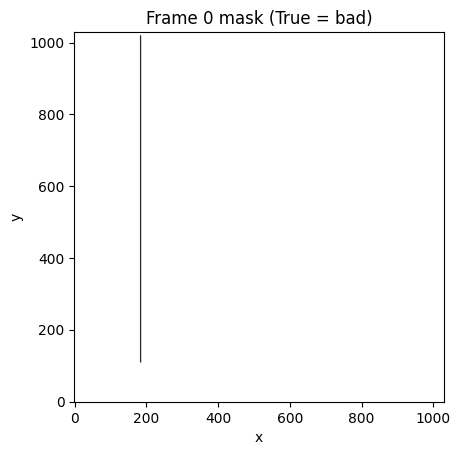

Mask shape: (52, 1030, 1030)
Total bad pixels per frame: 2733
Saved: /Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/bad_pixel_mask_strip.pickle


In [23]:
# %% [markdown]
# Inputs you need to set
nx, ny = 1030, 1030          # image width (x, columns), height (y, rows)
n_frames = 52                # number of frames to match
x_min, x_max = 184, 186      # inclusive x-range to mask (0-based indices)
y_min, y_max = 110, 1020     # inclusive y-range to mask (0-based indices)
output_pickle = "/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/bad_pixel_mask_strip.pickle"

# %%
import numpy as np
import pickle
import matplotlib.pyplot as plt

# sanity checks
assert 0 <= x_min <= x_max < nx, "x range out of bounds"
assert 0 <= y_min <= y_max < ny, "y range out of bounds"

# Base 2D mask
mask2d = np.zeros((ny, nx), dtype=bool)
mask2d[y_min:y_max+1, x_min:x_max+1] = True

# Duplicate for all frames → shape (n_frames, ny, nx)
mask3d = np.repeat(mask2d[np.newaxis, :, :], n_frames, axis=0)

# Quick visual check for one frame
plt.imshow(mask3d[0], origin='lower', cmap='gray_r')
plt.title("Frame 0 mask (True = bad)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Save to pickle
with open(output_pickle, "wb") as f:
    pickle.dump(mask3d, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Mask shape:", mask3d.shape)
print("Total bad pixels per frame:", mask2d.sum())
print("Saved:", output_pickle)

Cosmic mask: (52, 1030, 1030) bool bad count = 189488


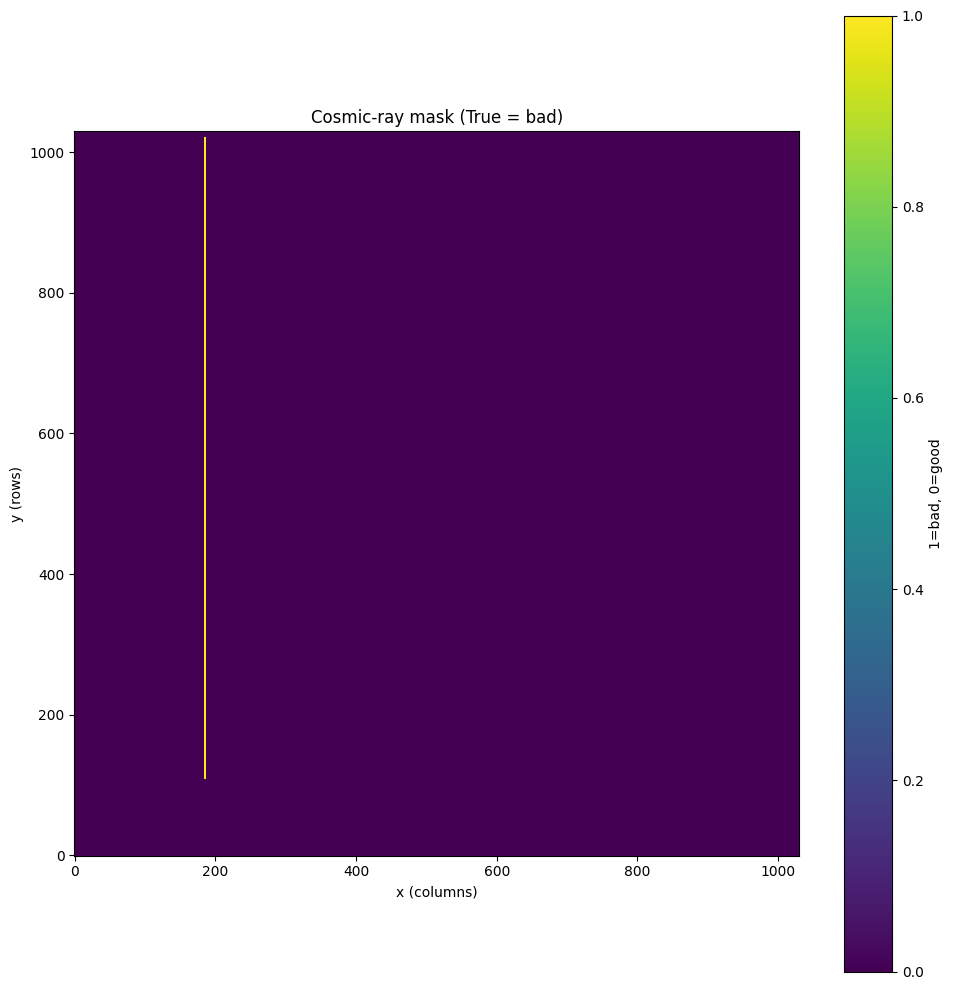

In [22]:
# %%
import pickle
import numpy as np
import matplotlib.pyplot as plt

def load_mask_pickle(path):
    with open(path, "rb") as f:
        m = pickle.load(f)
    m = np.asarray(m)
    if m.dtype != bool:
        # If stored as 0/1 or other numeric, coerce to boolean
        m = m.astype(bool)
    return m

def show_mask(mask, title="Mask (True = bad)"):
    plt.figure(figsize=(10, 10))
    # Visualize bad pixels as 1, good as 0; origin='lower' is often clearer
    plt.imshow(mask.astype(int), origin="lower", interpolation="none")
    plt.colorbar(label="1=bad, 0=good")
    plt.title(title)
    plt.xlabel("x (columns)")
    plt.ylabel("y (rows)")
    plt.tight_layout()
    plt.show()

# %%
cosmic_path = "/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/cosmic_pixel_mask_5sigma_clip.pickle"
cosmic_path = "/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/bad_pixel_mask_strip.pickle"
cosmic_mask = load_mask_pickle(cosmic_path)
print("Cosmic mask:", cosmic_mask.shape, cosmic_mask.dtype, "bad count =", cosmic_mask.sum())
show_mask(cosmic_mask[0], title="Cosmic-ray mask (True = bad)")

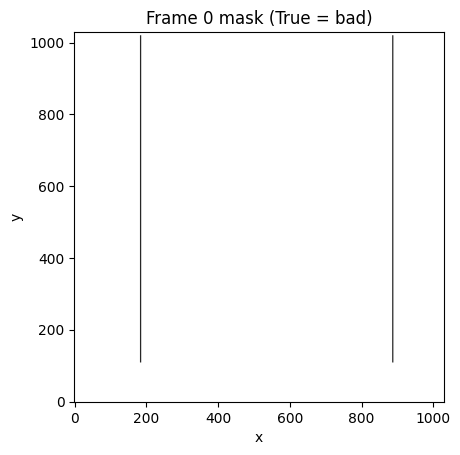

Mask shape: (52, 1030, 1030)
Total bad pixels per frame: 5466
Saved: /Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/bad_pixel_mask_double_strip.pickle


In [25]:

# Multi-rectangle bad-pixel mask (replicated across frames)
# - Provide any number of rectangles as (x_min, x_max, y_min, y_max), inclusive.
# - Creates a (n_frames, ny, nx) boolean mask with True marking "bad" pixels.

# Inputs you need to set
nx, ny      = 1030, 1030
n_frames    = 52
rectangles  = [
    (184, 186, 110, 1020),   # strip 1
    (886, 888, 110, 1020),    # strip 2
    # add more tuples here as needed
]
output_pickle = "/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/bad_pixel_mask_double_strip.pickle"

# %%
import numpy as np
import pickle
import matplotlib.pyplot as plt

def _check_rectangles(rects, nx, ny):
    """Sanity checks for rectangle bounds and ordering."""
    for i, (x_min, x_max, y_min, y_max) in enumerate(rects):
        assert 0 <= x_min <= x_max < nx, f"Rectangle {i}: x range out of bounds"
        assert 0 <= y_min <= y_max < ny, f"Rectangle {i}: y range out of bounds"

# Validate inputs
_check_rectangles(rectangles, nx, ny)

# Base 2D mask
mask2d = np.zeros((ny, nx), dtype=bool)

# Apply each rectangle (union of all regions)
for (x_min, x_max, y_min, y_max) in rectangles:
    mask2d[y_min:y_max+1, x_min:x_max+1] = True

# Replicate for all frames → shape (n_frames, ny, nx)
mask3d = np.repeat(mask2d[np.newaxis, :, :], n_frames, axis=0)

# Quick visual check for one frame
plt.imshow(mask3d[0], origin='lower', cmap='gray_r')
plt.title("Frame 0 mask (True = bad)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Save
with open(output_pickle, "wb") as f:
    pickle.dump(mask3d, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Mask shape:", mask3d.shape)
print("Total bad pixels per frame:", mask2d.sum())
print("Saved:", output_pickle)


In [28]:
# Gaia DR3 query: does this source have DR3 astrophysical parameters?
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # ensure DR3

coord = SkyCoord(ra=96.74348284*u.deg, dec=-46.82372560*u.deg, frame='icrs')

# 1″ cone search, then join to the DR3 astrophysical parameters table
radius = 1.0 * u.arcsec

qry = f"""
SELECT
  g.source_id, g.ra, g.dec, g.phot_g_mean_mag, g.parallax,
  ap.teff_gspphot, ap.mh_gspphot, ap.mh_gspphot_lower, ap.mh_gspphot_upper,
  ap.ag_gspphot, ap.ebpminrp_gspphot, ap.flags_gspphot
FROM gaiadr3.gaia_source AS g
JOIN gaiadr3.astrophysical_parameters AS ap
  ON g.source_id = ap.source_id
WHERE CONTAINS(
  POINT('ICRS', g.ra, g.dec),
  CIRCLE('ICRS', {coord.ra.deg}, {coord.dec.deg}, {radius.to(u.deg).value})
)=1
"""

job = Gaia.launch_job(qry)
tbl = job.get_results()
tbl

HTTPError: Error 400: 
Cannot parse query '
SELECT
 TOP 2000   g.source_id, g.ra, g.dec, g.phot_g_mean_mag, g.parallax,
  ap.teff_gspphot, ap.mh_gspphot, ap.mh_gspphot_lower, ap.mh_gspphot_upper,
  ap.ag_gspphot, ap.ebpminrp_gspphot, ap.flags_gspphot
FROM gaiadr3.gaia_source AS g
JOIN gaiadr3.astrophysical_parameters AS ap
  ON g.source_id = ap.source_id
WHERE CONTAINS(
  POINT('ICRS', g.ra, g.dec),
  CIRCLE('ICRS', 96.74348284, -46.8237256, 0.0002777777777777778)
)=1
' for job '1762426621512O': 1 unresolved identifiers: flags_gspphot [l.5 c.39 - l.5 c.55] !
 - Unknown column "ap.flags_gspphot" !
